## 목적
- 성능 평가의 기준이 되는 모델

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [3]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 334), (1679, 15))

In [4]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [5]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

In [7]:
df_merge.ym.value_counts().sort_index()

201902    239118
201903    209756
201904    240442
201905    212872
201906    255229
201907    337001
Name: ym, dtype: int64

## test 기간을 여러 개로 설정
1. train(4,5) valid(6) test(7)
2. train(2,3) valid(4) test(5)
3. train(6,7) valid(2) test(3)

In [53]:
ym_dict = {
    '201907': {'trn': ['201904', '201905'], 'val': '201906', 'tst': '201907'},
    '201905': {'trn': ['201902', '201903'], 'val': '201904', 'tst': '201905'},
    '201903': {'trn': ['201906', '201907'], 'val': '201902', 'tst': '201903'}
}

In [10]:
# feature
idx_col = 'svc_mgmt_num'
target_col = 'label_mfact_nm'
label_cols = [c for c in df_merge.columns if 'label_' in c]
# real_avg_arpu 값 이상함, 제거
feature_cols = [c for c in df_merge.columns if c not in [idx_col, 'ym', 'next_ym', 'real_avg_arpu', 'real_arpu_bf_m3'] + label_cols ]

In [32]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [33]:
# parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': df_merge[target_col].nunique(),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 60,
}

In [34]:
from sm_utils import evaluate

In [35]:
clf_dict = {}

In [36]:
for ym, dataset in ym_dict.items():
    print('trn: ', dataset['trn'])
    print('val: ', dataset['val'])
    print('tst: ', dataset['tst'])
    
    # split data
    df_trn = df_merge[df_merge['ym'].isin(dataset['trn'])]
    df_val = df_merge[df_merge['ym']==dataset['val']]
    df_tst = df_merge[df_merge['ym']==dataset['tst']]

    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target_col], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target_col], feature_name=feature_cols)
    
    # train
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    clf_dict[dataset['tst']] = clf
    
    # test
#     a = evaluate(df_tst[feature_cols], df_tst[target_col], clf, clf_name='lgb' )
    print('')

trn:  ['201904', '201905']
val:  201906
tst:  201907
Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 0.556693	valid_1's multi_logloss: 0.513054
[100]	training's multi_logloss: 0.529254	valid_1's multi_logloss: 0.496405
[150]	training's multi_logloss: 0.516421	valid_1's multi_logloss: 0.491845
[200]	training's multi_logloss: 0.508055	valid_1's multi_logloss: 0.490151
[250]	training's multi_logloss: 0.502085	valid_1's multi_logloss: 0.488893
[300]	training's multi_logloss: 0.49716	valid_1's multi_logloss: 0.488038
[350]	training's multi_logloss: 0.492823	valid_1's multi_logloss: 0.487459
[400]	training's multi_logloss: 0.488775	valid_1's multi_logloss: 0.487015
[450]	training's multi_logloss: 0.485066	valid_1's multi_logloss: 0.486662
[500]	training's multi_logloss: 0.481599	valid_1's multi_logloss: 0.486558
[550]	training's multi_logloss: 0.478244	valid_1's multi_logloss: 0.486439
[600]	training's multi_logloss: 0.475092	valid_1's multi_logl

In [37]:
clf_dict

{'201907': <lightgbm.basic.Booster at 0x7ff27d719f28>,
 '201905': <lightgbm.basic.Booster at 0x7ff27d72d5c0>,
 '201903': <lightgbm.basic.Booster at 0x7ff27d988438>}

### save model

In [39]:
for n, c in clf_dict.items():
    file_name = 'clf_' + '_'.join(n.split('_')[1:])

    with open(os.path.join(DATA_PATH, file_name + '.pkl'), 'wb') as f:
        pickle.dump(c, f, protocol=pickle.HIGHEST_PROTOCOL)

## interprete model

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [41]:
df_dict = {
    '201907': df_merge[df_merge.ym=='201907'],
    '201905': df_merge[df_merge.ym=='201905'],
    '201903': df_merge[df_merge.ym=='201903']
}

In [42]:
for ym, df in df_dict.items():
    df['pred'] = clf_dict[ym].predict(df[feature_cols]).argmax(axis=1)

In [43]:
df_dict['201907'].head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
1157417   7276311045       1  41.0       53819.00             0.0   
1157418   7287398294       2   7.0        8000.00             0.0   
1157419   7281235662       1  39.0       42528.00             0.0   
1157420   7281272424       1  34.0       51750.00             0.0   
1157421   7276301927       1  21.0       59534.75             0.0   

         last_eqp_buy_duration  location_weekday_visit_dong  \
1157417                    9.0                          9.0   
1157418                    0.0                          1.0   
1157419                    0.0                         12.0   
1157420                    0.0                         32.0   
1157421                    0.0                         10.0   

         mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
1157417                                17.0             258.582796   
1157418                                 0.0               0.000000   
1157419                                 0.0              89.864964   
1157420                                 0.0               0.013432   
1157421                                 0.0              54.961489   

         app_use_traffic_driver  ...  label_mktg_dt  label_tablet_yn  \
1157417                     0.0  ...       20190820                0   
1157418                     0.0  ...       20190524                0   
1157419                     0.0  ...       20190820                0   
1157420                     0.0  ...       20190820                0   
1157421                     0.0  ...       20190820                0   

         label_note_yn  label_disp_size_larg_yn  label_flagship_yn  \
1157417              1                        1                  1   
1157418              0                        0                  0   
1157419              1                        1                  1   
1157420              1                        1                  1   
1157421              1                        1                  1   

         label_eqp_mdl_ntwk  label_first_eqp_out_prc  label_out_prc  \
1157417                  5G                1496000.0      1496000.0   
1157418                  4G                 286000.0       286000.0   
1157419                  5G                1496000.0      1496000.0   
1157420                  5G                1248500.0      1248500.0   
1157421                  5G                1397000.0      1397000.0   

         label_price_range  pred  
1157417                  3     3  
1157418                  0     2  
1157419                  3     3  
1157420                  3     3  
1157421                  3     3  

[5 rows x 336 columns]

### accuracy w/ confusion matrix

In [46]:
def make_multi_confusion_matrix(df):
    
    df_cf = pd.DataFrame(
        confusion_matrix(df[target_col], df['pred'], labels=np.arange(df[target_col].nunique())), 
        columns = le_dict[target_col].classes_)
    
    df_cf['Sum'] = df_cf.sum(axis=1)
    df_cf = df_cf.append(df_cf.sum(axis=0), ignore_index=True)
    
    idx_list = list(le_dict[target_col].classes_) + ['Total']
    idx_dict = {}
    for i in np.arange(len(idx_list)):
        idx_dict[i] = idx_list[i]
        
    df_cf.rename(index=idx_dict, inplace=True)
    
    return df_cf

In [49]:
for ym, df in df_dict.items():
    print('='*50)
    print('ym: ', ym)
    print('samsung ratio: ', df[df[target_col]==3].shape[0]/df.shape[0])
    print('accuracy: ', accuracy_score(df[target_col], df['pred']))
    display(make_multi_confusion_matrix(df))

ym:  201907
samsung ratio:  0.8532734324230492
accuracy:  0.8556858881724386


Apple   LG전자   기타    삼성전자     Sum
Apple  16365    171    8    8295   24839
LG전자     784   3490   99   19504   23877
기타        33     27  405     266     731
삼성전자   12674   6654  119  268107  287554
Total  29856  10342  631  296172  337001

ym:  201905
samsung ratio:  0.7383122251869668
accuracy:  0.790968281408546


Apple  LG전자   기타    삼성전자     Sum
Apple  17083    11   46    9894   27034
LG전자     899   250   62   26754   27965
기타        11     0  371     325     707
삼성전자    6238   153  104  150671  157166
Total  24231   414  583  187644  212872

ym:  201903
samsung ratio:  0.782881061805145
accuracy:  0.8257594538416064


Apple  LG전자   기타    삼성전자     Sum
Apple  11716    17    3   16010   27746
LG전자     278   369   39   16057   16743
기타        14     7  303     729    1053
삼성전자    2775   532   87  160820  164214
Total  14783   925  432  193616  209756

## shap

In [50]:
from shap_tools import ShapModule

In [51]:
ids = le_dict['mfact_nm'].fit_transform(le_dict['mfact_nm'].classes_)
label_dict = dict(zip(ids,le_dict['mfact_nm'].classes_ ))

In [54]:
ym_dict

{'201907': {'trn': ['201904', '201905'], 'val': '201906', 'tst': '201907'},
 '201905': {'trn': ['201902', '201903'], 'val': '201904', 'tst': '201905'},
 '201903': {'trn': ['201906', '201907'], 'val': '201902', 'tst': '201903'}}

In [52]:
sm_dict = {}

In [55]:
for ym in df_dict.keys():
    sm_dict[ym] = ShapModule(df_merge[df_merge['ym'].isin(ym_dict[ym]['trn'])], clf_dict[ym],
                             feature_cols, idx_col = 'svc_mgmt_num', target_col = target_col,
                             model_type= 'python', label_dict = label_dict )

<class 'lightgbm.basic.Booster'>
<class 'lightgbm.basic.Booster'>
<class 'lightgbm.basic.Booster'>


In [57]:
for ym, sm in sm_dict.items():
    sm.calculate_shap_value(100000, stratified=True) 

elapsed time:  207.8325765132904
elapsed time:  57.58562874794006
elapsed time:  52.86446142196655


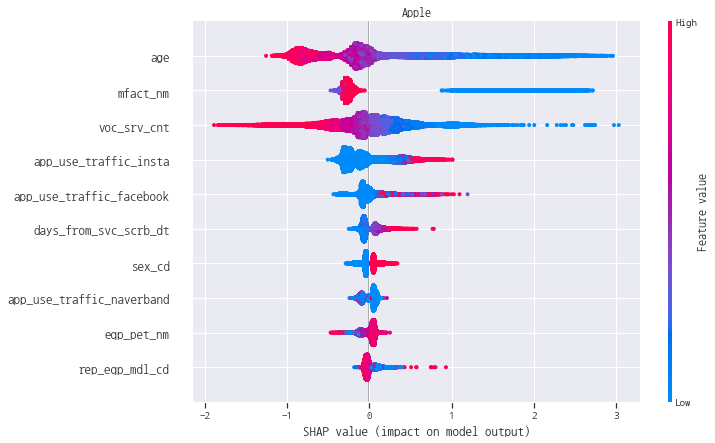

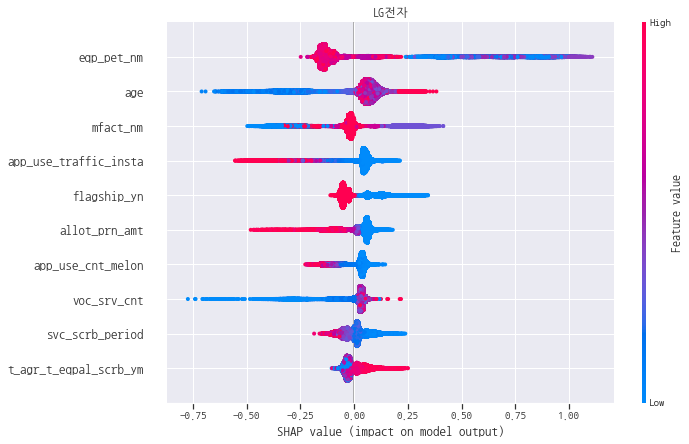

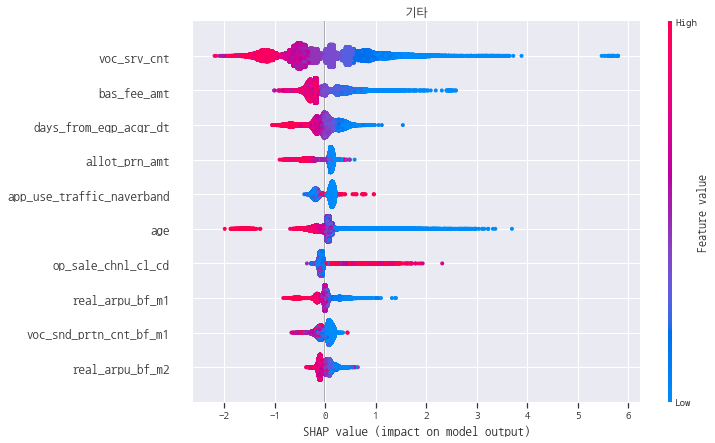

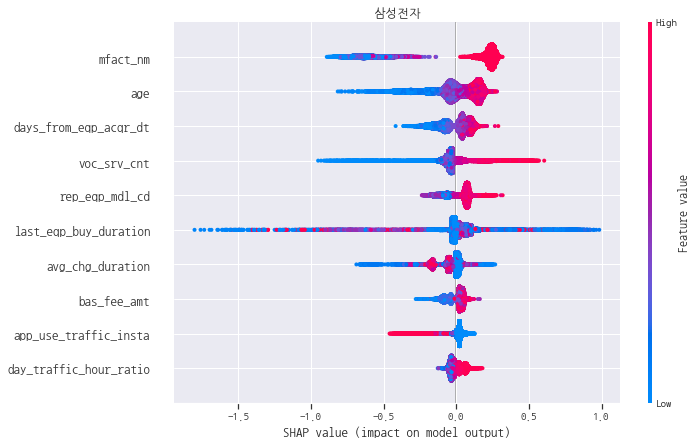

In [58]:
sm_dict['201907'].multiclass_summary_plot()

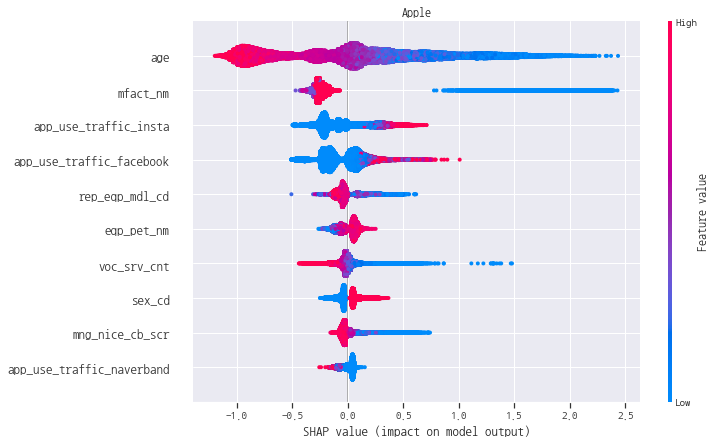

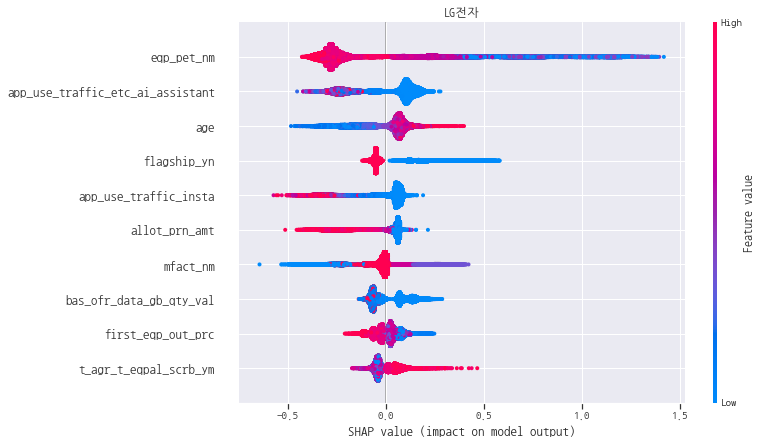

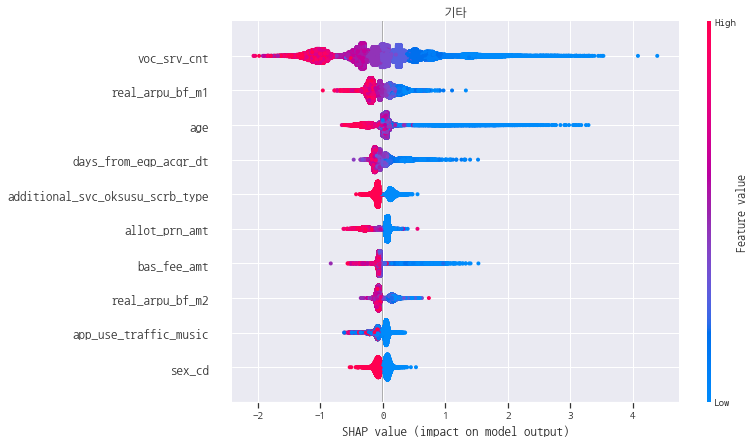

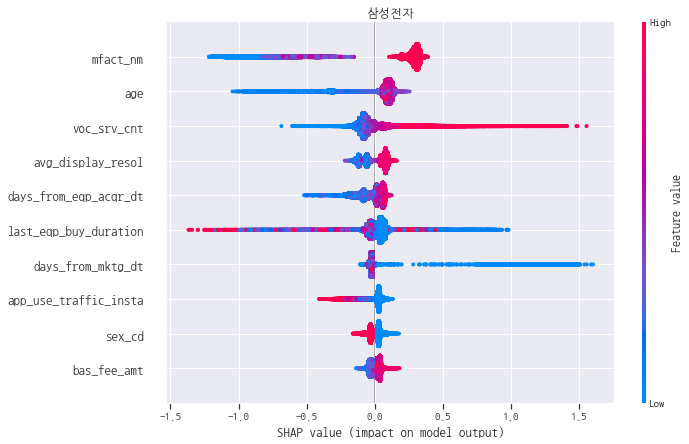

In [59]:
sm_dict['201905'].multiclass_summary_plot()

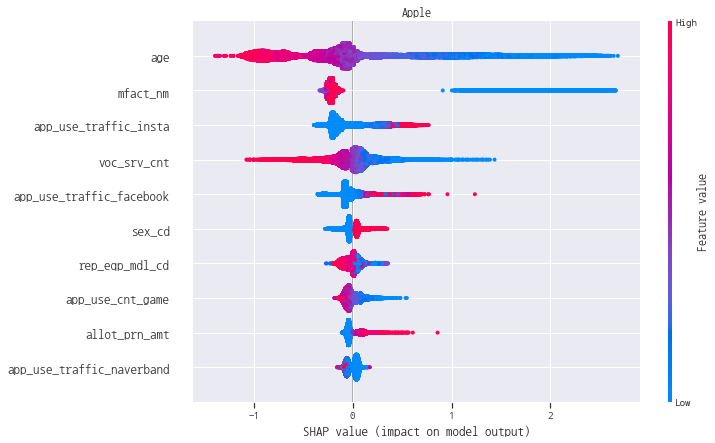

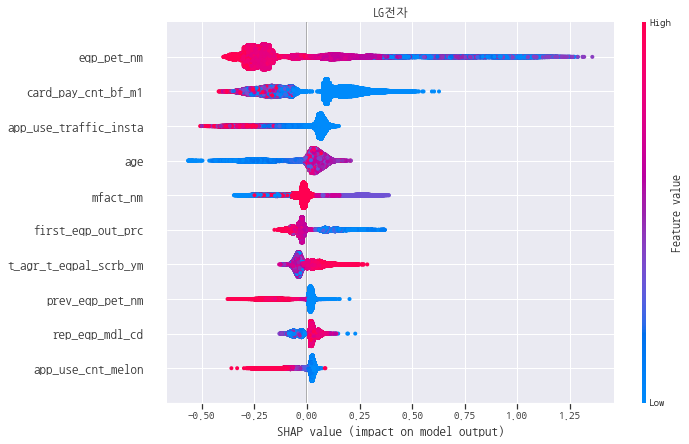

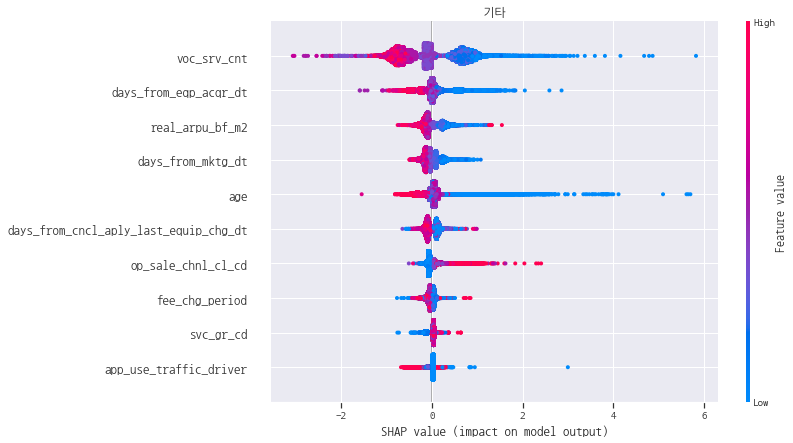

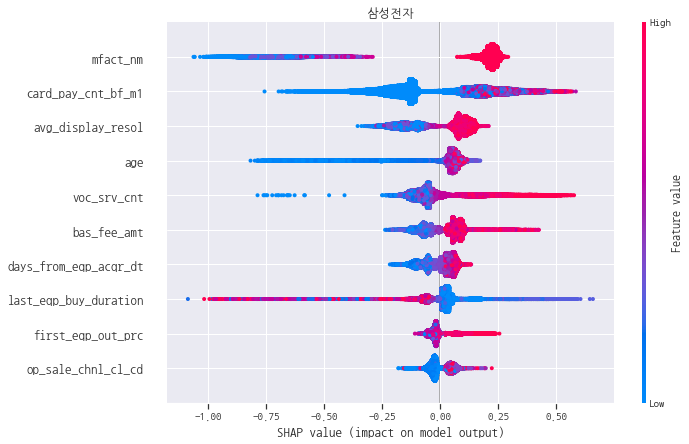

In [60]:
sm_dict['201903'].multiclass_summary_plot()

In [61]:
sm_dict['201907'].sample_df.shape, sm_dict['201905'].sample_df.shape, sm_dict['201903'].sample_df.shape

((99998, 335), (99998, 335), (99998, 335))

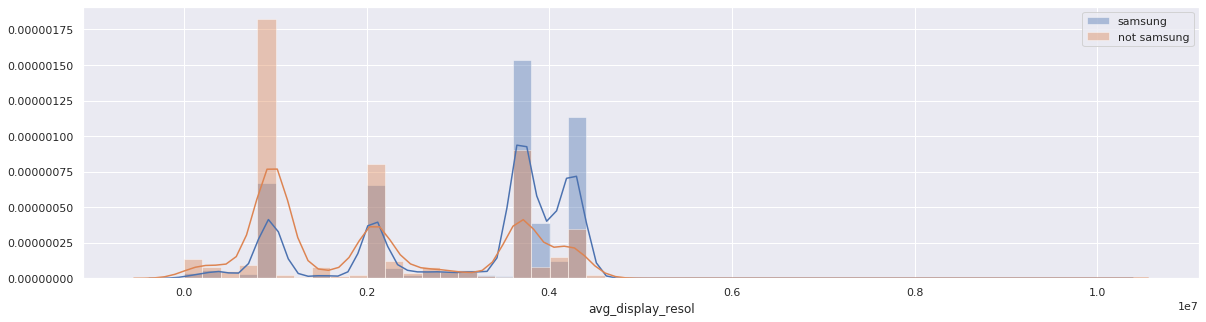

In [63]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201903'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

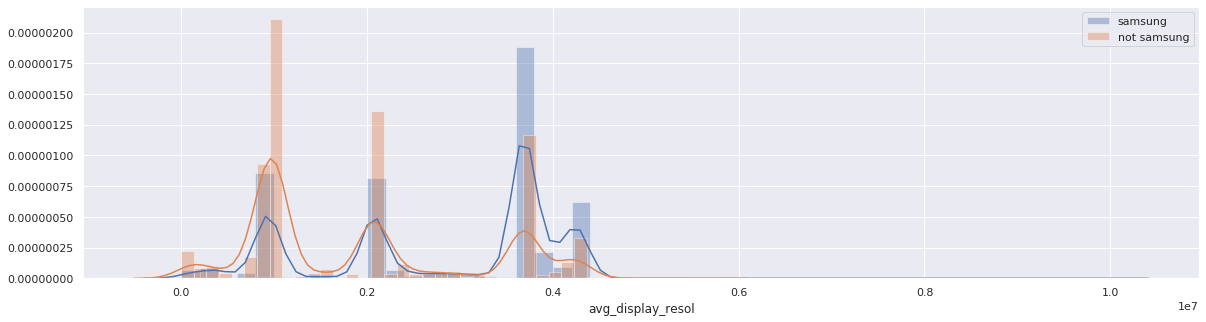

In [64]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201905'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

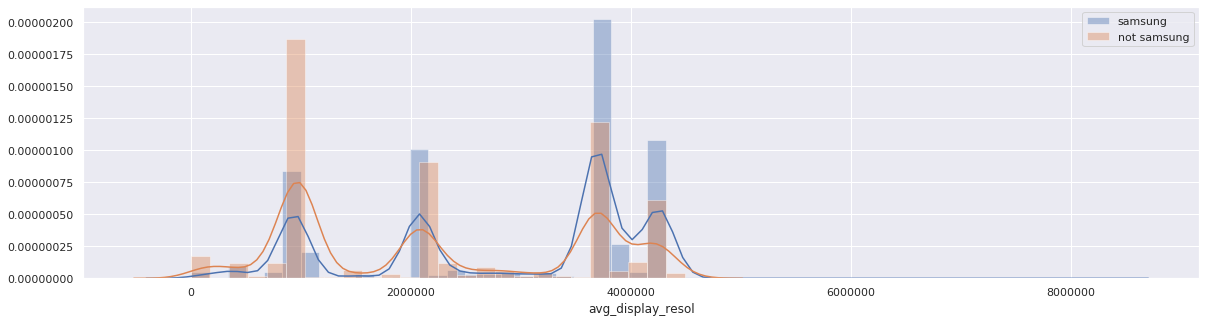

In [65]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201907'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

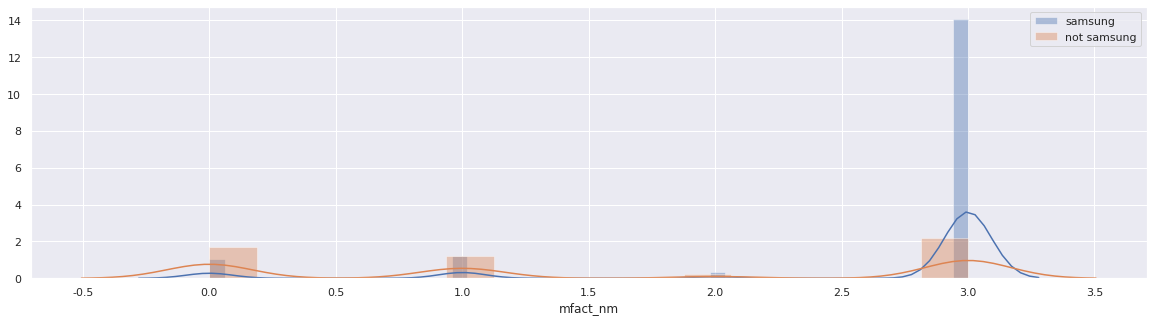

In [66]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201907'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['mfact_nm'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['mfact_nm'], label='not samsung')
plt.legend()

In [67]:
target_col

'label_mfact_nm'

In [71]:
df_merge.ym.value_counts()

201907    337001
201906    255229
201904    240442
201902    239118
201905    212872
201903    209756
Name: ym, dtype: int64

In [72]:
df_merge.ym.unique()

array(['201902', '201903', '201904', '201905', '201906', '201907'],
      dtype=object)

In [74]:
for ym in df_merge.ym.unique():
    print('='*50)
    print('ym: ', ym)
    display(df_merge[df_merge['ym']==ym].label_mfact_nm.value_counts().head(20))

ym:  201902


3    192660
0     28679
1     15883
2      1896
Name: label_mfact_nm, dtype: int64

ym:  201903


3    164214
0     27746
1     16743
2      1053
Name: label_mfact_nm, dtype: int64

ym:  201904


3    169062
1     41389
0     28428
2      1563
Name: label_mfact_nm, dtype: int64

ym:  201905


3    157166
1     27965
0     27034
2       707
Name: label_mfact_nm, dtype: int64

ym:  201906


3    195269
1     31932
0     27386
2       642
Name: label_mfact_nm, dtype: int64

ym:  201907


3    287554
0     24839
1     23877
2       731
Name: label_mfact_nm, dtype: int64

In [78]:
df_merge[(df_merge['ym']=='201902') & (df_merge['label_mfact_nm']==0)].label_eqp_pet_nm.value_counts()

아이폰XS                11867
아이폰XR                 6333
아이폰7                  3218
아이폰XS_MAX             3134
아이폰X                  2893
아이폰6S                  786
아이폰8                   375
아이폰7+                   43
아이폰8+                   14
IPAD PRO 12.9 3세대        7
IPAD PRO 11              4
R아이폰XS                   2
아이폰6                     1
IPAD PRO 10.5            1
IPAD 9.7                 1
Name: label_eqp_pet_nm, dtype: int64

In [77]:
df_merge[(df_merge['ym']=='201902') & (df_merge['label_mfact_nm']==1)].label_eqp_pet_nm.value_counts()

Q9             5737
G7             2504
X5(2018)       1647
X410           1513
G8             1445
V40             957
Q7              747
LG Folder       481
LTE 스마트 폴더      292
Q8(2018)        277
X4+             194
V35              66
BTS EDITION      18
V30               2
G6                2
V30+ ThinQ        1
Name: label_eqp_pet_nm, dtype: int64

In [73]:
for ym in df_merge.ym.unique():
    print('='*50)
    print('ym: ', ym)
    display(df_merge[df_merge['ym']==ym].label_eqp_pet_nm.value_counts().head(20))

ym:  201902


갤럭시S10              49368
갤럭시S10+             35459
갤럭시노트9              21394
갤럭시S8               14843
갤럭시S10E             12764
아이폰XS               11867
갤럭시 WIDE3           11065
갤럭시A6                9260
갤럭시A9 PRO (2018)     8764
갤럭시S9                6887
갤럭시노트8               6693
아이폰XR                6333
Q9                   5737
갤럭시A8 Star           4785
아이폰7                 3218
아이폰XS_MAX            3134
아이폰X                 2893
G7                   2504
갤럭시A7(2019)          2409
J5 2017              2303
Name: label_eqp_pet_nm, dtype: int64

ym:  201903


갤럭시S10 5G           49772
갤럭시S10              17343
갤럭시S10E             15520
갤럭시 WIDE3           12510
갤럭시노트9              12183
갤럭시S10+             12001
아이폰XS               11528
갤럭시S8               11443
갤럭시A9 PRO (2018)     7480
아이폰XR                6750
Q9                   5705
갤럭시노트8               5215
갤럭시A8 Star           3747
갤럭시S9                3527
아이폰XS_MAX            2958
아이폰X                 2800
갤럭시A6                2711
아이폰7                 2673
G8                   2429
갤럭시A7(2019)          2286
Name: label_eqp_pet_nm, dtype: int64

ym:  201904


갤럭시S10 5G           87714
V50                 24429
아이폰XS               11542
갤럭시S10E             10960
갤럭시 WIDE3            8649
아이폰XR                8047
갤럭시A30               7756
갤럭시S10               7323
갤럭시A9 PRO (2018)     7050
갤럭시S8                6918
갤럭시A8(2018)          5377
Q9                   4537
갤럭시노트9               4333
X4(2019)             4263
갤럭시 WIDE4            4114
갤럭시A8 Star           3408
아이폰7                 3193
갤럭시노트8               3148
갤럭시S10+              2969
아이폰X                 2436
Name: label_eqp_pet_nm, dtype: int64

ym:  201905


갤럭시S10 5G           93464
갤럭시 WIDE4           18646
V50                 15964
아이폰XR                9891
아이폰XS                9497
갤럭시S10E              9371
갤럭시A9 PRO (2018)     5132
갤럭시A30               4814
갤럭시S10               3265
갤럭시노트9               3209
아이폰7                 3065
갤럭시A50               2909
Q9                   2666
갤럭시A7(2019)          2480
갤럭시A8 Star           2403
갤럭시S8                2343
Q7                   2253
X6                   1971
갤럭시노트8               1860
아이폰6S                1772
Name: label_eqp_pet_nm, dtype: int64

ym:  201906


갤럭시S10 5G           122541
V50                  18158
갤럭시 WIDE4            17855
갤럭시노트9               11769
아이폰XR                11485
아이폰XS                10099
갤럭시A50                6923
갤럭시S10E               6737
갤럭시A30                3754
갤럭시A9 PRO (2018)      3730
X6                    3460
아이폰7                  2973
갤럭시노트8                2857
갤럭시S10                2725
갤럭시A7(2019)           2405
갤럭시A40                2399
Q9                    2396
Q7                    2256
갤럭시A8 Star            1906
갤럭시폴더2                1820
Name: label_eqp_pet_nm, dtype: int64

ym:  201907


갤럭시노트10             177329
갤럭시S10 5G            42699
갤럭시 WIDE4            18919
아이폰XR                10528
V50                   9546
아이폰XS                 8545
갤럭시S10E               7771
갤럭시A50                7395
갤럭시노트9                7283
갤럭시A40                4884
갤럭시A9 PRO (2018)      4467
아이폰7                  4136
X6                    3269
갤럭시A30                3035
Q9                    2882
갤럭시폴더2                2559
V40                   2165
갤럭시S10                2154
갤럭시노트8                2092
갤럭시A7(2019)           1885
Name: label_eqp_pet_nm, dtype: int64